In [1]:
import pathlib

import hydra
import torch
from captum.attr import Saliency
from torchvision.transforms import Compose
from captum.attr import visualization as viz

from tr_learn.data.dataset import PlateDataset
from tr_learn.model import PlateClassification
from tr_learn.utils import load_infer_info, remap_lighting_keys

In [2]:
config_path = pathlib.Path("exp", "cls_training", "config.yaml")

In [3]:
infer_info = load_infer_info(str(config_path))

In [4]:
config = infer_info.config

In [5]:
last_norm_transforms = Compose(hydra.utils.instantiate(config.datamodule.predict_load_info.transform._args_[-2:]))
config.datamodule.predict_load_info.transform._args_ = config.datamodule.predict_load_info.transform._args_[:-2]

In [6]:
config.datamodule.predict_load_info.batch_size = 1
config.datamodule.predict_load_info.num_workers = 0

In [7]:
datamodule = hydra.utils.instantiate(config.datamodule)

In [8]:
datamodule.setup("predict")

In [9]:
class_mapping = PlateDataset.get_label_mapping()

classes = [""] * len(class_mapping)

for label, index in class_mapping.items():
    classes[index] = label

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [11]:
model: PlateClassification = hydra.utils.instantiate(config.model)
model.eval()
model.to(device);

In [12]:
model.load_state_dict(remap_lighting_keys(torch.load(infer_info.checkpoints[0].file_path, map_location=device)))

<All keys matched successfully>

In [18]:
test_loader = datamodule.predict_dataloader()

In [19]:
explain_method = Saliency(model)

In [20]:
def explain(explainer, batch, last_transform, device, classes):
    assert batch[0].shape[0] ==  1, "Expected one sample only"
    images = batch[0].to(device)
    input = last_transform(images)

    with torch.inference_mode():
        predicted_logits = model(input)
        predicted_label = model.predict_class(predicted_logits).cpu()
    
    return images.cpu(), [classes[index.item()] for index in predicted_label], explainer.attribute(input).cpu()

In [21]:
def show_pred(image, pred_label, attr_map):
    signs = {"original_image": "all",
         "heat_map": "all",
         "blended_heat_map": "all",
        "alpha_scaling": "positive"
    }

    methods = list(signs.keys())

    _ = viz.visualize_image_attr_multiple(attr_map[0].permute(1, 2, 0).numpy(),
                                image[0].permute(1, 2, 0).numpy(),
                                methods=methods,
                                signs=list(signs.values()),
                                titles=[pred_label[0]] + methods[1:],
                                show_colorbar=True,
                                outlier_perc=1)

d:\AnacondaEnvs\stepik-tl\lib\site-packages\captum\_utils\gradient.py:57: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


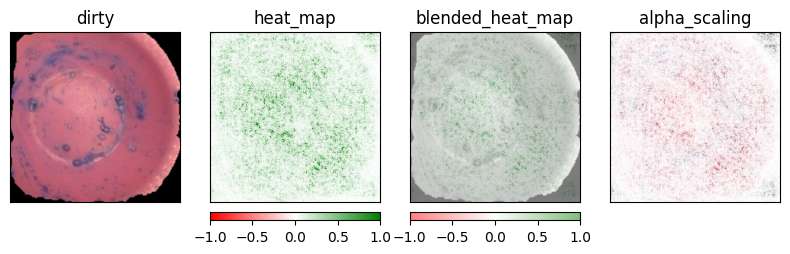

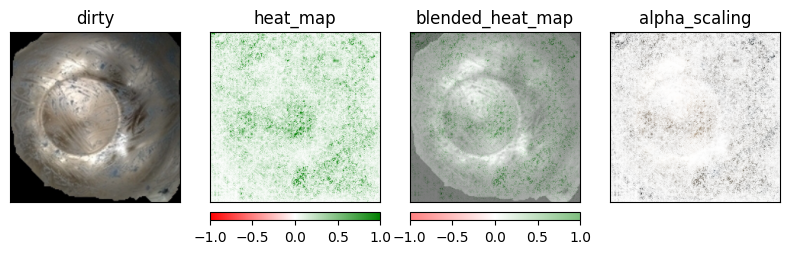

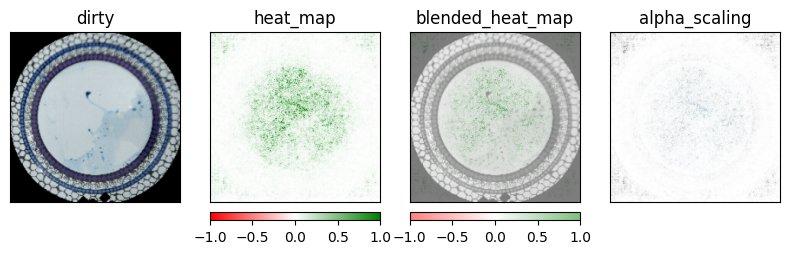

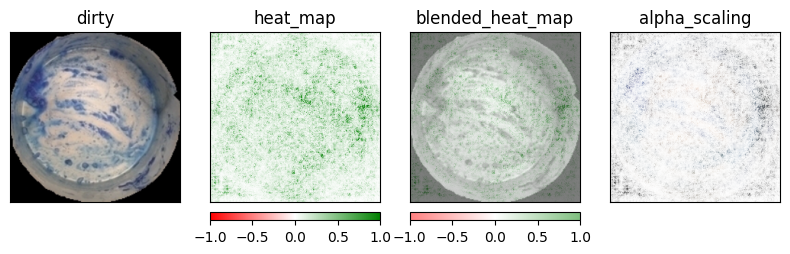

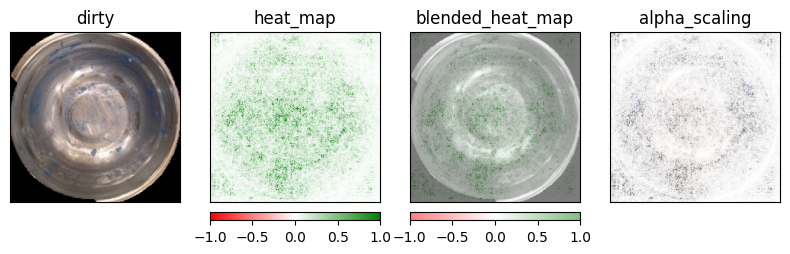

In [23]:
for i, batch in enumerate(test_loader):
    images, pred_labels, attr_map = explain(explain_method, batch, last_norm_transforms, device, classes) 

    show_pred(images, pred_labels, attr_map)
    
    if i > 3:
        break